# Get the Rating Matrix

In [41]:
!pip install apyori

  Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))': /simple/apyori/
  Retrying (Retry(total=3, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))': /simple/apyori/
  Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))': /simple/apyori/
  Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', ConnectionResetError(10

In [38]:
# !pip install mlxtend  


In [10]:
# !pip install efficient-apriori

In [11]:
import pandas as pd 
data_with_3 = pd.read_csv("../datasets/ratings_with_3_combinations_reduced.csv")[["rating", "bill"]]

data_with_3.head()

,rating,bill
0,1,"(745321, 666652)"
1,12,"(772494, 754574)"
2,1,"(772494, 745328)"
3,11,"(772494, 749358)"
4,1,"(772494, 745310)"


In [12]:
data_3_greater_1 = data_with_3[data_with_3.rating > 1] 

data_3_greater_1.head() 

,rating,bill
1,12,"(772494, 754574)"
3,11,"(772494, 749358)"
5,6,"(754574, 745328)"
6,23,"(754574, 749358)"
7,7,"(754574, 745310)"


In [13]:
# If the distribution of the quantity is normal, then it should be standardized, otherwise, the data should be normalized.
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,6))
plt.hist(data_3_greater_1['rating'], bins=100, ec='black', color='#2196f3')
plt.xlabel('ratings')
plt.ylabel('Nr. of Houses')
plt.show()

<Figure size 1000x600 with 1 Axes>

In [14]:
max(data_3_greater_1.rating),  min(data_3_greater_1.rating)

(2255, 2)

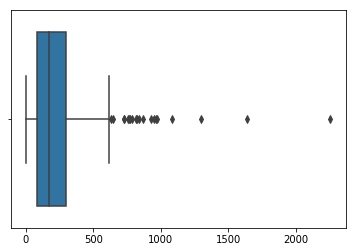

In [15]:
import seaborn as sns
sns.boxplot(data_3_greater_1['rating'].unique())

In [16]:
import numpy as np
data_3_greater_1_log = data_3_greater_1.copy() 
data_3_greater_1_log["rating"] = np.log(data_3_greater_1.rating) 

data_3_greater_1_log.head() 

,rating,bill
1,2.484907,"(772494, 754574)"
3,2.397895,"(772494, 749358)"
5,1.791759,"(754574, 745328)"
6,3.135494,"(754574, 749358)"
7,1.945910,"(754574, 745310)"


In [17]:
max(data_3_greater_1_log.rating),  min(data_3_greater_1_log.rating)

(7.720905251936779, 0.6931471805599453)

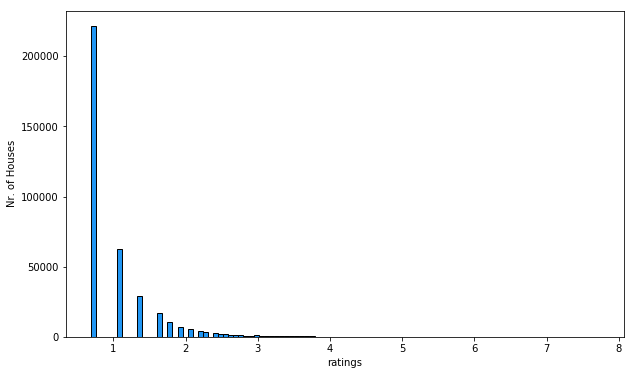

In [18]:
# If the distribution of the quantity is normal, then it should be standardized, otherwise, the data should be normalized.
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,6))
plt.hist(data_3_greater_1_log['rating'], bins=100, ec='black', color='#2196f3')
plt.xlabel('ratings')
plt.ylabel('Nr. of Houses')
plt.show()

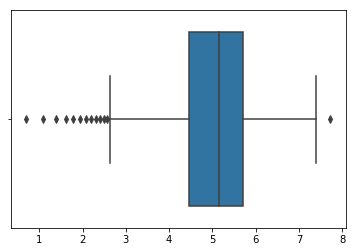

In [19]:
import seaborn as sns
sns.boxplot(data_3_greater_1_log['rating'].unique())

In [20]:
import numpy as np 
Q1 = np.percentile(data_3_greater_1_log['rating'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(data_3_greater_1_log['rating'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

print("data_3_greater_1_log has IQR:", IQR) 

data_3_greater_1_log has IQR: 0.6931471805599453


In [21]:
import pandas as pd
data_raw = pd.read_csv("../datasets/raw_data.csv") 

In [22]:
data_raw.head() 

,Unnamed: 0,optionId,bill
0,0,751839,1
1,1,751782,1
2,2,745321,1
3,3,666652,1
4,4,751873,2


In [24]:
transactions = [] 

bill = 1
option_bill = [] 

for index,row in data_raw.iterrows(): 
    if(row.bill == bill):
        option_bill.append(row.optionId)
    else:
        bill = row.bill 
        transactions.append(tuple(set(option_bill))) 
        option_bill.clear()
        option_bill.append(row.optionId)  


transactions[:3]

[(745321, 666652, 751782, 751839),
 (751873, 760125),
 (772494, 754574, 745328, 749358, 745310)]

# Model 1: Matrix Factorization Using Keras 

#### Data Prep for MF 

In [25]:
data_3_greater_1_log.head() 

,rating,bill
1,2.484907,"(772494, 754574)"
3,2.397895,"(772494, 749358)"
5,1.791759,"(754574, 745328)"
6,3.135494,"(754574, 749358)"
7,1.945910,"(754574, 745310)"


In [34]:
print(pd.__version__)


0.24.2


In [28]:
from ast import literal_eval

data_3_greater_1_log.bill = data_3_greater_1_log.bill.apply(literal_eval) 
data_3_greater_1_log.info() 

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

In [43]:
type(data_3_greater_1_log.bill.iat[0])

tuple

In [44]:
statement = (772494, 754574, 749358) 
s_set = set(statement) 
tuple(s_set.difference([772494]))

(749358, 754574)

In [45]:
def split_bill(statement):
    return [
        (tuple(set(statement).difference([statement[0]])), statement[0]),
        (tuple(set(statement).difference([statement[1]])), statement[1]),
        (tuple(set(statement).difference([statement[2]])), statement[2])
    ]

In [46]:
data_3_greater_1_log["option_count"] = data_3_greater_1_log.bill.apply(lambda x: len(x))
data_3_greater_1_log.tail() 

,rating,bill,option_count
4490148,0.693147,"(774694, 767718, 767721)",3
4490843,0.693147,"(774590, 774319)",2
4490847,0.693147,"(774469, 774590, 774319)",3
4491087,0.693147,"(764896, 786771, 774571)",3
4492451,0.693147,"(748899, 748868, 752949)",3


In [47]:
sublist_by_2 = data_3_greater_1_log[data_3_greater_1_log.option_count == 2]

In [48]:
sublist_by_2_concat = pd.concat([
    sublist_by_2,
    pd.DataFrame(data_3_greater_1_log[data_3_greater_1_log.option_count == 2].bill.to_list(), columns=["LHS", "RHS"], index=sublist_by_2.index)
], axis=1)
sublist_by_2_concat.head()

,rating,bill,option_count,LHS,RHS
1,2.484907,"(772494, 754574)",2,772494,754574
3,2.397895,"(772494, 749358)",2,772494,749358
5,1.791759,"(754574, 745328)",2,754574,745328
6,3.135494,"(754574, 749358)",2,754574,749358
7,1.945910,"(754574, 745310)",2,754574,745310


In [49]:
sublist_by_3 = data_3_greater_1_log[data_3_greater_1_log.option_count == 3]
sublist_by_3.head() 

,rating,bill,option_count
12,0.693147,"(772494, 754574, 749358)",3
18,0.693147,"(754574, 745328, 745310)",3
34,1.098612,"(751649, 751591, 751532)",3
35,0.693147,"(751649, 751591, 751597)",3
36,0.693147,"(751649, 751595, 751532)",3


In [50]:
replicated_rows = pd.DataFrame(np.repeat(sublist_by_3.values, 3, axis=0), columns=sublist_by_3.columns)

sublists_by_3_reduced = []  
for item in sublist_by_3.bill.to_list():
    sublists_by_3_reduced += split_bill(item) 

sublists_by_3_reduced = pd.DataFrame(sublists_by_3_reduced, columns=["LHS", "RHS"])

sublist_by_3_concat = pd.concat([
    replicated_rows, 
    sublists_by_3_reduced
], axis=1)

sublist_by_3_concat.head() 

,rating,bill,option_count,LHS,RHS
0,0.693147,"(772494, 754574, 749358)",3,"(749358, 754574)",772494
1,0.693147,"(772494, 754574, 749358)",3,"(749358, 772494)",754574
2,0.693147,"(772494, 754574, 749358)",3,"(754574, 772494)",749358
3,0.693147,"(754574, 745328, 745310)",3,"(745328, 745310)",754574
4,0.693147,"(754574, 745328, 745310)",3,"(745310, 754574)",745328


In [51]:
dataset_combined_MF = pd.concat([sublist_by_3_concat, sublist_by_2_concat], axis=0, ignore_index=True)
dataset_combined_MF.head()  

,rating,bill,option_count,LHS,RHS
0,0.693147,"(772494, 754574, 749358)",3,"(749358, 754574)",772494
1,0.693147,"(772494, 754574, 749358)",3,"(749358, 772494)",754574
2,0.693147,"(772494, 754574, 749358)",3,"(754574, 772494)",749358
3,0.693147,"(754574, 745328, 745310)",3,"(745328, 745310)",754574
4,0.693147,"(754574, 745328, 745310)",3,"(745310, 754574)",745328


In [52]:
dataset_combined_MF.option_count.unique() 

array([3, 2], dtype=object)

In [53]:
sublist_by_2_concat["LHS_C"] = sublist_by_2_concat.LHS.astype('category').cat.codes.values
sublist_by_2_concat["RHS_C"] = sublist_by_2_concat.RHS.astype('category').cat.codes.values

sublist_by_2_concat.head() 

,rating,bill,option_count,LHS,RHS,LHS_C,RHS_C
1,2.484907,"(772494, 754574)",2,772494,754574,4116,3329
3,2.397895,"(772494, 749358)",2,772494,749358,4116,2675
5,1.791759,"(754574, 745328)",2,754574,745328,3303,2414
6,3.135494,"(754574, 749358)",2,754574,749358,3303,2675
7,1.945910,"(754574, 745310)",2,754574,745310,3303,2403


In [54]:
len(sublist_by_2_concat.RHS_C.unique()), len(sublist_by_2_concat.LHS_C.unique())

(4800, 4764)

## Building MF Model 

### Model: With 2's Combine 

In [55]:
from tensorflow import keras
from keras.optimizers import Adam 

n_rhs, n_lhs = len(sublist_by_2_concat.RHS_C.unique()), len(sublist_by_2_concat.LHS_C.unique())
n_latent_factors = 20
# input, embedding --> 
lhs_input = keras.layers.Input(shape=(1,), name="lhs-item") 
lhs_embedding = keras.layers.Embedding(n_lhs + 1, n_latent_factors, name="lhs-embeddings")(lhs_input) 
lhs_vec = keras.layers.Flatten(name="flatten-lhs")(lhs_embedding) 

rhs_input= keras.layers.Input(shape=(1,), name="rhs-item")
rhs_embedding = keras.layers.Embedding(n_rhs + 1, n_latent_factors, name="rhs-embeddings")(rhs_input) 
rhs_vec = keras.layers.Flatten(name="flatten-rhs")(rhs_embedding)

product = keras.layers.dot([lhs_vec, rhs_vec], axes=1, name="dot-product") 

model = keras.Model([lhs_input, rhs_input], product) 


In [56]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lhs-item (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 rhs-item (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 lhs-embeddings (Embedding)     (None, 1, 20)        95300       ['lhs-item[0][0]']               
                                                                                                  
 rhs-embeddings (Embedding)     (None, 1, 20)        96020       ['rhs-item[0][0]']               
                                                                                              

In [57]:
initial_weights = model.get_weights()

In [58]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(sublist_by_2_concat[["RHS_C", "LHS_C"]], sublist_by_2_concat.rating, test_size=0.10) 
X_train[:5], y_train[:5]

(         RHS_C  LHS_C
 256257     673   1087
 789833    3598   3719
 166816    2577   3967
 723830     638   3526
 3435879   4782   4594, 256257     0.693147
 789833     4.779123
 166816     1.791759
 723830     1.098612
 3435879    0.693147
 Name: rating, dtype: float64)

In [59]:
len(X_train.RHS_C.unique()), len(X_test.RHS_C.unique())

(4728, 3016)

In [60]:
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=3, )

In [61]:
history = model.fit(
    [X_train.LHS_C, X_train.RHS_C], 
    y_train,
    validation_data=([X_test.LHS_C, X_test.RHS_C], y_test),
    epochs=100, 
    verbose=0,
    callbacks=[early_stopping]
)

In [62]:
sublist_by_2_concat.rating.max(), sublist_by_2_concat.rating.min() 

(7.720905251936779, 0.6931471805599453)

In [63]:
model.get_layer(name='lhs-embeddings').get_weights()

[array([[-1.43288940e-01,  2.30015125e-02, -1.99171886e-01, ...,
         -2.09974684e-02, -1.82193637e-01,  1.23048164e-01],
        [-2.17553694e-02,  3.74995358e-02, -2.60378361e-01, ...,
         -5.79555392e-01, -2.97640592e-01, -3.31055939e-01],
        [-2.83776850e-01, -4.10547614e-01,  3.11083853e-01, ...,
          4.57062662e-01, -2.49804601e-01,  2.84135938e-01],
        ...,
        [ 3.09014410e-01,  3.47050250e-01,  9.49043095e-01, ...,
         -6.85475320e-02,  4.84121501e-01,  7.26142228e-01],
        [ 1.14147149e-01,  1.74109340e-01,  1.70064494e-01, ...,
         -3.33399221e-04,  4.25760984e-01,  2.30516255e-01],
        [ 2.15731561e-04, -1.94909424e-03,  2.18639486e-02, ...,
         -1.13184564e-02, -1.45648234e-02, -4.59014177e-02]], dtype=float32)]

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

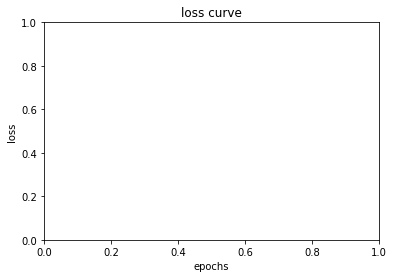

In [64]:
import matplotlib.pyplot as plt 

plt.title("loss curve")
plt.xlabel("epochs")
plt.ylabel("loss")
pd.DataFrame(history.history)["loss"].plot(figsize=(10,6)) 
pd.DataFrame(history.history)[["mse", "mae"]].plot(figsize=(10,6))
plt.show() 

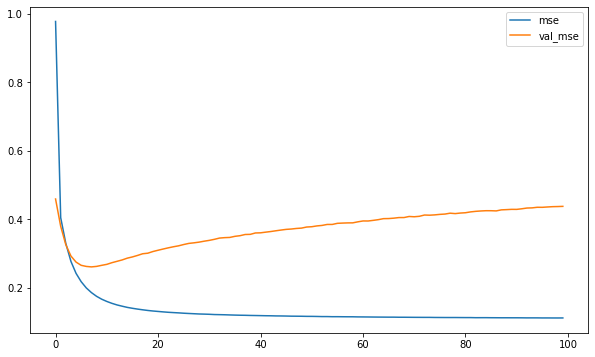

In [ ]:
pd.DataFrame(history.history)[["mse", "val_mse"]].plot(figsize=(10,6))
plt.show() 

In [65]:
model.set_weights(initial_weights)

In [66]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",patience=3)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
history = model.fit(
    [X_train.LHS_C, X_train.RHS_C], 
    y_train,
    validation_data=([X_test.LHS_C, X_test.RHS_C], y_test),
    epochs=100, 
    callbacks=[early_stopping]
)

Epoch 1/100
1930/5959 [========>.....................] - ETA: 9s - loss: 1.8480 - mae: 1.1559 - mse: 1.8480

KeyboardInterrupt: 

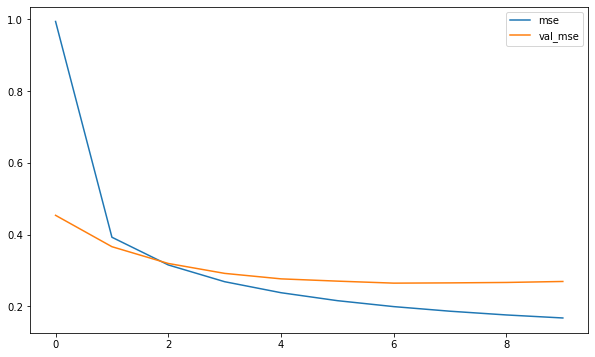

In [ ]:
pd.DataFrame(history.history)[["mse", "val_mse"]].plot(figsize=(10,6))
plt.show() 

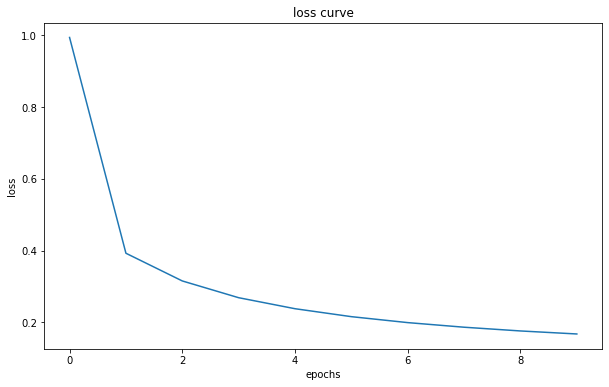

In [ ]:
plt.title("loss curve")
plt.xlabel("epochs")
plt.ylabel("loss")
pd.DataFrame(history.history)["loss"].plot(figsize=(10,6)) 
plt.show() 

In [ ]:
lhs_embddings = model.get_layer(name='lhs-embeddings').get_weights()[0]
lhs_embddings

array([[ 0.05444679, -0.15497532, -0.03975978, ..., -0.21779673,
        -0.04953405, -0.19831128],
       [-0.161224  , -0.12987842, -0.16163631, ...,  0.01651466,
        -0.02219854, -0.07976579],
       [-0.19332881, -0.26915818,  0.2052333 , ...,  0.2672566 ,
        -0.34760576, -0.24698003],
       ...,
       [-0.20373599,  0.03305611,  0.08360191, ..., -0.20985837,
         0.15588471,  0.17243434],
       [-0.49274397,  0.09540527,  0.38966033, ...,  0.6062298 ,
         0.25041145,  0.20531167],
       [ 0.03706029,  0.0066414 ,  0.04201052, ..., -0.00484476,
        -0.02308061,  0.03915468]], dtype=float32)

In [ ]:
rhs_embddings = model.get_layer(name='rhs-embeddings').get_weights()[0]
rhs_embddings

array([[ 8.5571408e-03, -2.8197123e-02, -3.8261961e-02, ...,
        -3.5836436e-02, -1.4554966e-02,  4.9517576e-02],
       [-3.6809194e-01, -3.0140632e-01, -3.1525329e-01, ...,
        -1.5369308e-02, -1.2778670e-01, -1.0495425e-01],
       [-4.9172781e-02, -1.6342056e-01,  3.9757162e-02, ...,
        -1.9887355e-01,  5.0370052e-02, -2.0195502e-01],
       ...,
       [-2.2258058e-01,  2.6415446e-01,  1.5530334e-01, ...,
         5.1415974e-01,  4.5965257e-01,  3.2164985e-01],
       [-4.1087806e-01,  2.1958532e-02,  5.0764877e-01, ...,
         6.3703400e-01,  5.1544762e-01,  1.2466612e-01],
       [-3.5418153e-02,  4.3734163e-04,  4.7830831e-02, ...,
        -3.7035920e-02,  2.3733329e-02,  2.3336079e-02]], dtype=float32)

In [ ]:
def recommend(option_in_category, number_of_options=5):
  options = lhs_embddings[option_in_category]@rhs_embddings.T
  mids = np.argpartition(options, -number_of_options)[-number_of_options:]
  
  return mids

In [ ]:
sublist_by_2_concat.LHS.value_counts()[:20]

753600    1139
753376    1117
753350     826
525100     809
753536     799
751873     772
753509     744
753609     740
751600     733
778629     708
751754     707
759397     644
753517     639
751526     632
753572     613
716035     579
746304     545
753314     545
760352     544
748802     541
Name: LHS, dtype: int64

In [ ]:
sublist_by_2_concat[sublist_by_2_concat.LHS == 759397].head()     # RHS = 721495, LHS = 751839

,rating,bill,option_count,LHS,RHS,LHS_C,RHS_C
1233,1.609438,"(759397, 753355)",2,759397,753355,3678,3238
1234,4.875197,"(759397, 753357)",2,759397,753357,3678,3240
1235,2.397895,"(759397, 755827)",2,759397,755827,3678,3576
1236,2.197225,"(759397, 753301)",2,759397,753301,3678,3206
1237,3.737670,"(759397, 702423)",2,759397,702423,3678,1398


In [ ]:
id_list = recommend(
    3678,
    10
)

sublist_by_2_concat.query("RHS_C in @id_list").RHS.unique() 

array([753285, 751581, 753433, 753431, 753436, 759397, 753357, 753268,
       677927, 677910], dtype=int64)

In [ ]:
id_list

array([1398, 4763, 4762, 4759, 4755], dtype=int64)

### Model.2 : With 3's Combine 

In [67]:
dataset_combined_MF.head() 

,rating,bill,option_count,LHS,RHS
0,0.693147,"(772494, 754574, 749358)",3,"(749358, 754574)",772494
1,0.693147,"(772494, 754574, 749358)",3,"(749358, 772494)",754574
2,0.693147,"(772494, 754574, 749358)",3,"(754574, 772494)",749358
3,0.693147,"(754574, 745328, 745310)",3,"(745328, 745310)",754574
4,0.693147,"(754574, 745328, 745310)",3,"(745310, 754574)",745328


In [68]:
dataset_combined_MF["LHS_C"] = dataset_combined_MF.LHS.astype('category').cat.codes.values
dataset_combined_MF["RHS_C"] = dataset_combined_MF.RHS.astype('category').cat.codes.values

dataset_combined_MF.head() 

,rating,bill,option_count,LHS,RHS,LHS_C,RHS_C
0,0.693147,"(772494, 754574, 749358)",3,"(749358, 754574)",772494,0,4244
1,0.693147,"(772494, 754574, 749358)",3,"(749358, 772494)",754574,1,3410
2,0.693147,"(772494, 754574, 749358)",3,"(754574, 772494)",749358,2,2753
3,0.693147,"(754574, 745328, 745310)",3,"(745328, 745310)",754574,3,3410
4,0.693147,"(754574, 745328, 745310)",3,"(745310, 754574)",745328,4,2489


In [69]:
len(dataset_combined_MF["RHS_C"].unique()), len(dataset_combined_MF["LHS_C"].unique())

(4898, 111164)

In [70]:
n_rhs, n_lhs = len(dataset_combined_MF.RHS_C.unique()), len(dataset_combined_MF.LHS_C.unique())
n_latent_factors = 20
# input, embedding --> 
lhs_input = keras.layers.Input(shape=(1,), name="lhs-item") 
lhs_embedding = keras.layers.Embedding(n_lhs + 1, n_latent_factors, name="lhs-embeddings")(lhs_input) 
lhs_vec = keras.layers.Flatten(name="flatten-lhs")(lhs_embedding) 

rhs_input= keras.layers.Input(shape=(1,), name="rhs-item")
rhs_embedding = keras.layers.Embedding(n_rhs + 1, n_latent_factors, name="rhs-embeddings")(rhs_input) 
rhs_vec = keras.layers.Flatten(name="flatten-rhs")(rhs_embedding)

product = keras.layers.dot([lhs_vec, rhs_vec], axes=1, name="dot-product") 
model_2 = keras.Model([lhs_input, rhs_input], product) 

model_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [71]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(dataset_combined_MF[["RHS_C", "LHS_C"]], dataset_combined_MF.rating, test_size=0.10) 
X_train_3[:5], y_train_3[:5]

(        RHS_C   LHS_C
 247068   3304   51028
 652590   3134  106409
 603084   2530  106795
 470925   3921   63845
 46974     766   15184, 247068    0.693147
 652590     1.94591
 603084    0.693147
 470925     1.09861
 46974     0.693147
 Name: rating, dtype: object)

In [72]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",patience=3)
history = model_2.fit(
    [X_train_3.LHS_C, X_train_3.RHS_C], 
    np.array(y_train_3, dtype=float),
    validation_data=([X_test_3.LHS_C, X_test_3.RHS_C], np.array(y_test_3, dtype=float)),
    epochs=100, 
    callbacks=[early_stopping]
)

Epoch 1/100
20182/20182 [==============================] - 879s 44ms/step - loss: 0.5427 - mae: 0.5728 - mse: 0.5427 - val_loss: 0.2842 - val_mae: 0.3985 - val_mse: 0.2842
Epoch 2/100
20182/20182 [==============================] - 845s 42ms/step - loss: 0.2197 - mae: 0.3398 - mse: 0.2197 - val_loss: 0.2351 - val_mae: 0.3564 - val_mse: 0.2351
Epoch 3/100
20182/20182 [==============================] - 830s 41ms/step - loss: 0.1733 - mae: 0.2937 - mse: 0.1733 - val_loss: 0.2184 - val_mae: 0.3423 - val_mse: 0.2184
Epoch 4/100
20182/20182 [==============================] - 824s 41ms/step - loss: 0.1502 - mae: 0.2700 - mse: 0.1502 - val_loss: 0.2139 - val_mae: 0.3406 - val_mse: 0.2139
Epoch 5/100
20182/20182 [==============================] - 793s 39ms/step - loss: 0.1365 - mae: 0.2574 - mse: 0.1365 - val_loss: 0.2121 - val_mae: 0.3397 - val_mse: 0.2121
Epoch 6/100
20182/20182 [==============================] - 817s 40ms/step - loss: 0.1263 - mae: 0.2455 - mse: 0.1263 - val_loss: 0.2142 - va

In [77]:
from helpers import save_with_pickle

save_with_pickle(model_2.get_weights(), "../datasets/weights_model_2.pickle")

# Model 2: Apriori (apyori Module)

In [42]:
from apyori import apriori 

ModuleNotFoundError: No module named 'apyori'

In [9]:
associations = apriori(
    transactions,
    min_length = 2,
    max_length=4,
    min_support = 0.0001,
    min_confidence = 0.0001,
    min_lift = 0.0001,
)

associations = list(associations)
len(associations)

8374

In [10]:
association = associations[100]
print(association)
print("support", association.support)
print(association.ordered_statistics)
print("right", association.ordered_statistics[0].items_add)
print("left", association.ordered_statistics[0].items_base)
print("confidence", association.ordered_statistics[0].confidence)
print("lift", association.ordered_statistics[0].lift)


RelationRecord(items=frozenset({635458}), support=0.0007728733714453959, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({635458}), confidence=0.0007728733714453959, lift=1.0)])
support 0.0007728733714453959
[OrderedStatistic(items_base=frozenset(), items_add=frozenset({635458}), confidence=0.0007728733714453959, lift=1.0)]
right frozenset({635458})
left frozenset()
confidence 0.0007728733714453959
lift 1.0


In [11]:
rules = [] 
for association in associations:
    if len(association.ordered_statistics) > 1: 
        rules.append(association)

In [12]:
len(rules)

5228

In [13]:
rules 

[RelationRecord(items=frozenset({525099, 525100}), support=0.0011010378585273694, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({525099, 525100}), confidence=0.0011010378585273694, lift=1.0), OrderedStatistic(items_base=frozenset({525099}), items_add=frozenset({525100}), confidence=0.24224021592442646, lift=11.800967554677243), OrderedStatistic(items_base=frozenset({525100}), items_add=frozenset({525099}), confidence=0.05363812938891378, lift=11.800967554677243)]),
 RelationRecord(items=frozenset({525099, 701998}), support=0.00010734352381186054, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({525099, 701998}), confidence=0.00010734352381186054, lift=1.0), OrderedStatistic(items_base=frozenset({525099}), items_add=frozenset({701998}), confidence=0.023616734143049933, lift=4.914089258293739), OrderedStatistic(items_base=frozenset({701998}), items_add=frozenset({525099}), confidence=0.022335673261008295, lift=4.91408925